# CH7 Ensemble Learning and Random Forests


#### Voting


In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_moons(n_samples=500, noise=.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('SVC', SVC(random_state=42))
])

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(random_state=42)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('SVC', SVC(random_state=42))])

In [3]:
voting_clf.estimators

[('Logistic Regression', LogisticRegression(random_state=42)),
 ('Random Forest', RandomForestClassifier(random_state=42)),
 ('SVC', SVC(random_state=42))]

In [4]:
try:
    voting_clf.estimators[0][1].score(X_test, y_test)
except:
    print("NotFittedError: This LogisticRegression instance is not fitted yet.\n Call 'fit' with appropriate arguments before using this estimator.")

NotFittedError: This LogisticRegression instance is not fitted yet.
 Call 'fit' with appropriate arguments before using this estimator.


In [5]:
voting_clf.estimators_[0].score(X_test, y_test)

0.864

> notice the difference between clone (fitted estimator) which in **clf.estimators\_** and the original (not fitted) which in **clf.estimators**


let's try all individuals..


In [6]:
voting_clf.named_estimators_

{'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'SVC': SVC(random_state=42)}

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, 'Score = ', clf.score(X_test, y_test))

Logistic Regression Score =  0.864
Random Forest Score =  0.896
SVC Score =  0.896


In [8]:
voting_clf.predict(X_test[[0]])

array([1], dtype=int64)

In [9]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, 'predicts:  ', *clf.predict(X_test[[0]]))

Logistic Regression predicts:   1
Random Forest predicts:   1
SVC predicts:   0


voting score:


In [10]:
voting_clf.score(X_test, y_test)

0.912

> notice the default type of voting in voting classifier is <font color='orange'>hard voting</font>, let's try <font color='orange'>soft voting</font> which we assume it will **outperforms** the other version.

the main reason behind this assumption is that voting classifier will give more weight for confident prediction than others. ex: probs: .90, .40, .49 ---hard voting prediction---> 1 0 0 -> 0. ----soft voting prediction---- (.90 + .40 + .49 )/3 = .59 which will be predicted ->1.


In [11]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['SVC'].probability = True
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(random_state=42)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('SVC', SVC(probability=True, random_state=42))],
                 voting='soft')

In [12]:
voting_clf.score(X_test, y_test)

0.92

wow!


#### Bagging and Pasting


In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [15]:
bag_clf.score(X_test, y_test)

0.904

##### Out Of Bag Evaluation


In [16]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42, oob_score=True
                            )

In [17]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=42)

In [18]:
bag_clf.oob_score_

0.9253333333333333

In [19]:
bag_clf.oob_decision_function_[:5]

array([[0.35579515, 0.64420485],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.01030928, 0.98969072],
       [0.03174603, 0.96825397]])

Pasting


In [20]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42,
                            bootstrap=False  # without replacement
                            )

In [21]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(bootstrap=False, estimator=DecisionTreeClassifier(),
                  max_samples=100, n_estimators=500, n_jobs=-1,
                  random_state=42)

In [22]:
bag_clf.score(X_test, y_test)

0.92

---


##### Random Patches and Random Subspaces


1- random spaces


this bagging example is for using only one feature with all instances


In [51]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            n_jobs=-1, random_state=42,
                            bootstrap=False, max_samples=1.0,
                            # keeping all instances (each selected once)
                            max_features=1, bootstrap_features=False
                            )

bag_clf.fit(X_train, y_train)
print(bag_clf.score(X_test, y_test))

0.784


In [53]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            n_jobs=-1, random_state=42,
                            bootstrap=False, max_samples=1.0,
                            # keeping all instances (each selected once)

                            max_features=2, bootstrap_features=True
                            # sampling all features, but may select same feature twice
                            )

bag_clf.fit(X_train, y_train)
print(bag_clf.score(X_test, y_test))

0.848


In [55]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            n_jobs=-1, random_state=42,
                            bootstrap=False, max_samples=1.0,
                            # keeping all instances (each selected once)

                            max_features=2, bootstrap_features=False
                            # sampling all features, only feature can be selected once (bootstrap = False -->> without replacement)
                            )

bag_clf.fit(X_train, y_train)
print(bag_clf.score(X_test, y_test))

0.88


2- random patches: sampling both instances and features


In [61]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            n_jobs=-1, random_state=42,
                            bootstrap=False, max_samples=100,
                            # sampling instances (each selected once)

                            max_features=2, bootstrap_features=False
                            # sampling all features, only feature can be selected once (bootstrap = False -->> without replacement)
                            )

bag_clf.fit(X_train, y_train)
print(bag_clf.score(X_test, y_test))

0.92


---


#### Random Forests


In [69]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, max_features='sqrt',
                            n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.912

random forest uses random spaces technique. ( keeping all instances but picking only $\sqrt{n}$ features for example)


> at each node only a random subset of the features is considered for splitting (as discussed earlier).


#### Extra Trees


is the same as random forest but split the nodes based on random thresholds for features (rather than best value that reduced impurity in Decision Tree)
hyper parameter for this in decision tree is -> splitter = 'random'
or use Extra trees from sklearn


In [82]:
from sklearn.ensemble import ExtraTreesClassifier
for i in range(10):
    exT = ExtraTreesClassifier(n_jobs=-1)
    exT.fit(X_train, y_train)
    print(exT.score(X_test, y_test))

0.896
0.896
0.896
0.896
0.888
0.888
0.88
0.896
0.888
0.888


it's very random random forest!


#### Feature Importance


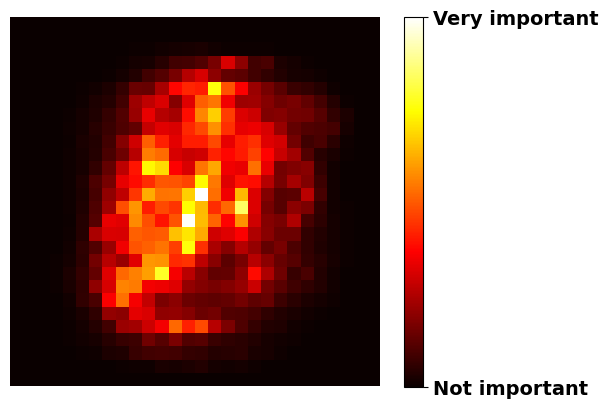

In [84]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

---
